- This notebook performs the cell type enrichment analysis between spatial moduels. 

In [1]:
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import anndata
import pandas as pd

### 1. Prepare data

- Load the data for the anterior and posterior MERFISH section 

In [ ]:
%%time

# load 1311 posterior 
Donor_1311_posterior_adata  = anndata.read_h5ad(r'/../../../MERFISH_adata_QC/mapmycell_annotated_adata/MER2_Gpe_Gpi_CaPu_1311__MERFISH_annotated.h5ad')
spatialModuleAnnotation = pd.read_csv(r'/../../../MERFISH_data_analysis/spatialDomain_analysis/processed_data/donor_1311_PosteriorMERFISH/GroupLevelspatialModule_MatrixStriosome_included_cleaned_final.csv', index_col=0)
Donor_1311_posterior_adata.obs = Donor_1311_posterior_adata.obs.join(spatialModuleAnnotation[['Final_Major_region_label','MatrixStriosome_label']])


print('load 1311 posterior .....')


# # load 2427 posterior 
Donor_2427_posterior_adata = anndata.read_h5ad(r'/../../../MERFISH_adata_QC/mapmycell_annotated_adata/MER4_Gpe_Gpi_2724__MERFISH_annotated.h5ad')
spatialModuleAnnotation = pd.read_csv(r'/../../../MERFISH_data_analysis/spatialDomain_analysis/processed_data/donor_2724_PosteriorMERFISH/GroupLevelspatialModule_MatrixStriosome_included_cleaned_final.csv', index_col=0)
Donor_2427_posterior_adata.obs = Donor_2427_posterior_adata.obs.join(spatialModuleAnnotation[['Final_Major_region_label','MatrixStriosome_label']])
print('load 2427 posterior .....')


# # load 2427 anterior 
Donor_2427_anterior_adata = anndata.read_h5ad(r'/../../../MERFISH_adata_QC/mapmycell_annotated_adata/MER1_CaPuNAC_2427__MERFISH_annotated.h5ad')
spatialModuleAnnotation = pd.read_csv(r'/../../../MERFISH_data_analysis/spatialDomain_analysis/processed_data/chip5_AnteriorMERFISH/GroupLevelspatialModule_MatrixStriosome_included_cleaned_final.csv', index_col=0)
Donor_2427_anterior_adata.obs = Donor_2427_anterior_adata.obs.join(spatialModuleAnnotation[['Final_Major_region_label','MatrixStriosome_label']])
print('load 2427 anterior .....')


# # load 3924 anterior 
Donor_3924_anterior_adata = anndata.read_h5ad(r'/../../../MERFISH_data_analysis/MERFISH_adata_QC/mapmycell_annotated_adata/MER5_CaPuNAc_3924__MERFISH_annotated.h5ad')
spatialModuleAnnotation = pd.read_csv(r'/../../../MERFISH_data_analysis/spatialDomain_analysis/processed_data/donor_3924_AnteriorMERFISH/GroupLevelspatialModule_MatrixStriosome_included_cleaned_final.csv', index_col=0)
Donor_3924_anterior_adata.obs = Donor_3924_anterior_adata.obs.join(spatialModuleAnnotation[['Final_Major_region_label','MatrixStriosome_label']])
print('load 3924 anterior  .....')

load 1311 posterior .....
load 2427 posterior .....
load 2427 anterior .....
load 3924 anterior  .....
CPU times: user 1min 26s, sys: 16.6 s, total: 1min 42s
Wall time: 1min 47s


In [3]:
# concatenate the data
adata = anndata.concat([Donor_1311_posterior_adata,Donor_2427_posterior_adata,Donor_2427_anterior_adata,Donor_3924_anterior_adata],
                       label = 'samples',
                        keys= ['Donor_1311_posterior','Donor_2427_posterior','Donor_2427_anterior','Donor_3924_anterior'],
                        fill_value=0,
                        join='outer',
                        merge='same' ,
                        index_unique='_' # make the cell index unique
                        ) 

In [4]:
adata

AnnData object with n_obs × n_vars = 3250780 × 769
    obs: 'volm', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'Neighborhood_label', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Class_label', 'Class_name', 'Class_bootstrapping_probability', 'Subclass_label', 'Subclass_name', 'Subclass_bootstrapping_probability', 'Group_label', 'Group_name', 'Group_bootstrapping_probability', 'Cluster_label', 'Cluster_name', 'Cluster_alias', 'Cluster_bootstrapping_probability', 'Final_Major_region_label', 'MatrixStriosome_label', 'samples'
    obsm: 'X_raw', 'X_spatial', 'X_spatial_rotated', 'X_umap', 'X_pca'
    layers: 'X_raw'

In [5]:
np.unique(adata.obs['Final_Major_region_label'])

array(['BNST', 'Caudate', 'Ependymal_zone', 'Gpe', 'Gpi',
       'GrayMatter_fibers', 'Internal_Capsule', 'IsCj', 'NAC_core',
       'NAC_shell', 'Putamen', 'Surrounding layers', 'Thalamus',
       'anterior_commissure', 'whitematter(Olfactory area)'], dtype=object)

- Define helper functions. 

In [6]:
def get_confusion_count_df(df, col1, col2):
    '''Get the confusion matrix between two categorical columns in a dataframe.'''
    assert((col1 != 'count') and (col2 != 'count'))
    count_df = df[[col1, col2]].copy()
    count_df['count'] = 1
    
    conf_df = pd.pivot_table(count_df, index=[col1], columns=[col2], 
                              values='count', aggfunc=np.sum).fillna(0)
    
    return conf_df 
        
def get_expected_count_df(conf_df):
    mtx = conf_df.values
    
    total_count = np.sum(mtx)
    row_fractions = np.sum(mtx, axis=1) / total_count
    col_fractions = np.sum(mtx, axis=0) / total_count
    
    expect_fractions = row_fractions[:, np.newaxis] * col_fractions[np.newaxis, :]
    expected_count_df = pd.DataFrame(data=expect_fractions * total_count, 
                                     index=conf_df.index, columns=conf_df.columns)
    
    return expected_count_df

- Build null distribution based on the enrichment score of each cell type in each sptial modules. 

In [7]:
from tqdm import tqdm 
import warnings
warnings.filterwarnings("ignore") 
num_shuffles = 1000
null_dist = []
for _ in tqdm(np.arange(num_shuffles), desc = 'building null distribution'):

    obs_df = adata.obs.copy()
    samples = np.unique(obs_df['samples'])
    # shuffle the cell-type label within each sample 
    for sample in samples:
        keep = obs_df['samples'] == sample
        shuffled_label = np.random.permutation(obs_df.loc[keep,'Group_name'].values)
        obs_df.loc[keep,'Group_name'] = shuffled_label

    # Get the confusion matrix data frame
    conf_df = get_confusion_count_df(obs_df, 'Group_name', 'Final_Major_region_label')

    # Calculate the enrichment matrix data frame
    expected_count_df = get_expected_count_df(conf_df)
    region_enrichment_df = conf_df / expected_count_df.values
    null_dist += [region_enrichment_df.values]
null_dist = np.stack(null_dist)

building null distribution:   0%|          | 0/1000 [00:00<?, ?it/s]

building null distribution: 100%|██████████| 1000/1000 [25:50<00:00,  1.55s/it]


- Compute Significance

In [8]:
obs_df = adata.obs.copy()
samples = np.unique(obs_df['samples'])
# Get the confusion matrix data frame
conf_df = get_confusion_count_df(obs_df, 'Group_name', 'Final_Major_region_label')
# Calculate the enrichment matrix data frame
expected_count_df = get_expected_count_df(conf_df)
observed_region_enrichment_df = conf_df / expected_count_df.values
pval_Mat = np.zeros_like(observed_region_enrichment_df.values)
zscore_Mat = np.zeros_like(observed_region_enrichment_df.values)

for i,celltype in enumerate(observed_region_enrichment_df.index):
    for j,region in enumerate(observed_region_enrichment_df.columns):
        null_dist_1D = null_dist[:,i,j]
        obs_val = observed_region_enrichment_df.iloc[i,j].item()
        mu = np.nanmean(null_dist_1D)
        std = np.nanstd(null_dist_1D)
        zscore_Mat[i,j] = (obs_val - mu)/std
        pval_Mat[i,j] = (1 + (null_dist_1D >= obs_val).sum())/(1 + len(null_dist_1D))
        

In [9]:
np.where(observed_region_enrichment_df.index == 'STRd D2 Matrix MSN')

(array([49]),)

(1000,)

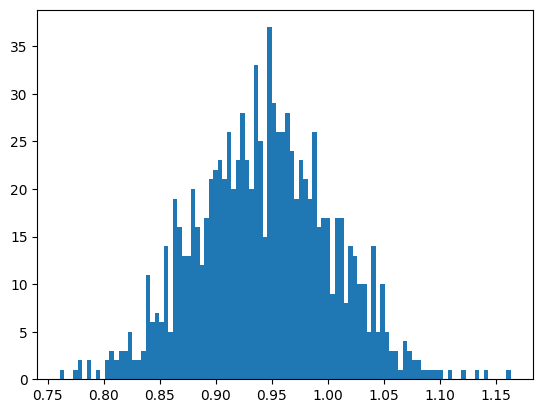

In [10]:
import matplotlib.pyplot as plt
plt.hist(null_dist[:,49,7],bins = 100);
null_dist_1D.shape

 - correct for multiple testing: FDR

In [11]:
import scipy
pvals = pval_Mat.ravel()
adj_pval = scipy.stats.false_discovery_control(pvals)
adj_pval = np.reshape(adj_pval,pval_Mat.shape)
# if not significant replace with NaN
not_sign = adj_pval > 0.05
observed_enrich = observed_region_enrichment_df.values.copy()
observed_enrich[not_sign] = 0
observed_region_enrichment_df_filtered = pd.DataFrame(observed_enrich, index = observed_region_enrichment_df.index, columns = observed_region_enrichment_df.columns)
adj_pval_df = pd.DataFrame(adj_pval,index = observed_region_enrichment_df.index, columns = observed_region_enrichment_df.columns)


In [12]:
adj_pval.shape,observed_region_enrichment_df_filtered.shape

((60, 15), (60, 15))

In [13]:
# manually order regions 
region_order = ['Caudate','Putamen','NAC_core','NAC_shell',  'Gpe', 'Gpi','BNST','Thalamus','whitematter(Olfactory area)','Ependymal_zone', 'GrayMatter_fibers','Internal_Capsule','anterior_commissure']

# region_order = ['Caudate','Putamen', 'Gpe', 'Gpi','BNST','GrayMatter_fibers','Internal_Capsule']

observed_region_enrichment_df_filtered = observed_region_enrichment_df_filtered[region_order].copy()
adj_pval_df = adj_pval_df[region_order].copy() # also for the pval df, make sure the region order is the same 

In [14]:
region_name_mapper = {'whitematter(Olfactory area)':'Olfactory area', 'GrayMatter_fibers':'Striatopallidal_fibers','Internal_Capsule':'White_matter'}

In [15]:
observed_region_enrichment_df_filtered = observed_region_enrichment_df_filtered.rename(columns = region_name_mapper)
adj_pval_df = adj_pval_df.rename(columns = region_name_mapper)

- change Group-name to short-name 

In [16]:
import pandas as pd
Allen_short_name = pd.read_csv(r'/mnt/Z/Lab/Bereket_public/Human_basal_ganglion_project/Reference_snRNAseq_Allen/HumanBG_scRNA_seq_Allen/HMBA_BG_consensus_annotation_consensus_anno_pre_print.csv')
group = Allen_short_name['Group'].values
short_group_name = Allen_short_name['short_name_group'].values

short_name_mapper = dict(zip(group,short_group_name))


In [17]:
short_name_mapper

{'STRd D1 Matrix MSN': 'STRd D1 Matrix',
 'STRd D1 Striosome MSN': 'STRd D1 Striosome',
 'STRd D2 Matrix MSN': 'STRd D2 Matrix',
 'STRd D2 Striosome MSN': 'STRd D2 Striosome',
 'STRv D1 MSN': 'STRv D1',
 'STRv D2 MSN': 'STRv D2',
 'STRd D2 StrioMat Hybrid MSN': 'STRd D2 Hybrid',
 'STR D1D2 Hybrid MSN': 'STR D1D2 Hybrid',
 'STRv D1 NUDAP MSN': 'STRv D1 NUDAP',
 'OT D1 ICj': 'OT D1 ICj',
 'GPe MEIS2-SOX6 GABA': 'GPe MEIS2-SOX6',
 'AMY-SLEA-BNST GABA': 'CN GABA',
 'AMY-SLEA-BNST D1 GABA': 'CN D1 GABA',
 'SN SEMA5A GABA': 'SN SEMA5A',
 'SN EBF2 GABA': 'SN EBF2',
 'OB FRMD7 GABA': 'OB FRMD7',
 'OB Dopa-GABA': 'OB Dopa-GABA',
 'GPi Shell': 'GPi Shell',
 'GPi Core': 'GPi Core',
 'SN GATA3-PVALB GABA': 'SN GATA3-PVALB',
 'GPe SOX6-CTXND1 GABA': 'GPe SOX6-CTXND1',
 'ZI-HTH GABA': 'ZI-HTH GABA',
 'SN-VTR-HTH GATA3-TCF7L2 GABA': 'F M GATA3-TCF7L2',
 'SN GATA3-PAX8 GABA': 'SN GATA3-PAX8',
 'GPe-NDB-SI LHX6-LHX8-GBX1 GABA': 'CN LHX6-GBX1',
 'VIP GABA': 'VIP',
 'LAMP5-CXCL14 GABA': 'LAMP5-CXCL14',
 

In [18]:
observed_region_enrichment_df_filtered = observed_region_enrichment_df_filtered.rename(index = short_name_mapper)
adj_pval_df = adj_pval_df.rename(index = short_name_mapper)

In [19]:
region_order = list(observed_region_enrichment_df_filtered.columns)
region_order

['Caudate',
 'Putamen',
 'NAC_core',
 'NAC_shell',
 'Gpe',
 'Gpi',
 'BNST',
 'Thalamus',
 'Olfactory area',
 'Ependymal_zone',
 'Striatopallidal_fibers',
 'White_matter',
 'anterior_commissure']

In [20]:
cmap = ["#e6194B", "#3cb44b", "#ffe119", "#4363d8", "#f58231", "#911eb4", "#42d4f4", "#f032e6", "#bfef45",
        "#d8165d", "#469990", "#dcbeff", "#9A6324", "#fffac8", "#800000", "#aaffc3", "#808000", "#ffd8b1",
        "#000075", "#a9a9a9"]
region_cmap = {r:cmap[i%len(cmap)] for i,r in enumerate(region_order)}
region_cmap

{'Caudate': '#e6194B',
 'Putamen': '#3cb44b',
 'NAC_core': '#ffe119',
 'NAC_shell': '#4363d8',
 'Gpe': '#f58231',
 'Gpi': '#911eb4',
 'BNST': '#42d4f4',
 'Thalamus': '#f032e6',
 'Olfactory area': '#bfef45',
 'Ependymal_zone': '#d8165d',
 'Striatopallidal_fibers': '#469990',
 'White_matter': '#dcbeff',
 'anterior_commissure': '#9A6324'}

In [21]:
list(list(region_cmap.values()))

['#e6194B',
 '#3cb44b',
 '#ffe119',
 '#4363d8',
 '#f58231',
 '#911eb4',
 '#42d4f4',
 '#f032e6',
 '#bfef45',
 '#d8165d',
 '#469990',
 '#dcbeff',
 '#9A6324']

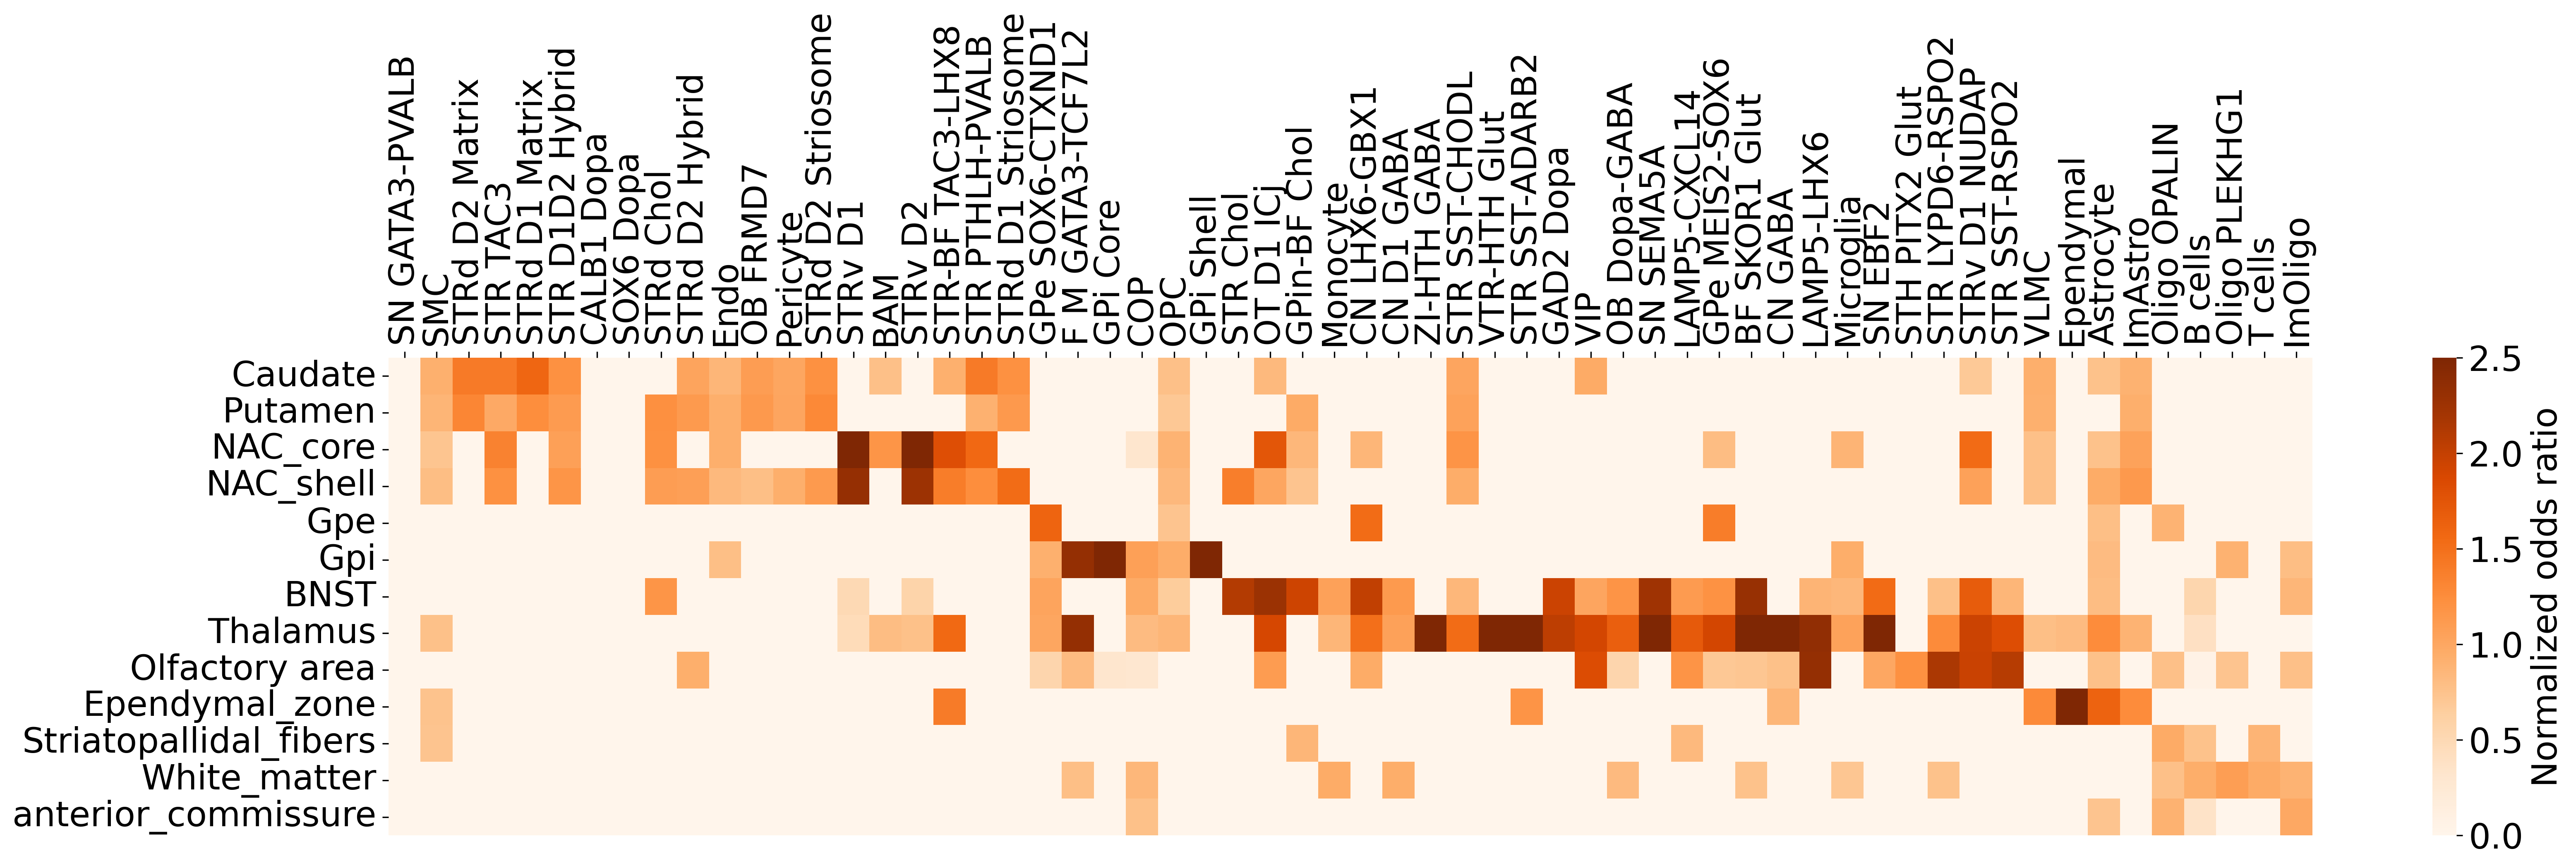

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.size'] = 20

keep = np.isnan(observed_region_enrichment_df_filtered.values).all(axis=-1)
observed_region_enrichment_df_filtered = observed_region_enrichment_df_filtered[~keep].copy()
heatmap_matrix = np.log1p(observed_region_enrichment_df_filtered.values)


significant_celltypes = np.array(observed_region_enrichment_df_filtered.index)
spatial_modules = np.array(observed_region_enrichment_df_filtered.columns)

enriched_idx = np.nanargmax(heatmap_matrix,axis=-1)
sort_idx = np.argsort(enriched_idx)
significant_celltypes_sorted = significant_celltypes[sort_idx] # Also sort the celltypes
heatmap_matrix = heatmap_matrix[sort_idx,:].copy()

fig,ax = plt.subplots(1,1,dpi = 300, figsize = (25,5))
sns.heatmap(heatmap_matrix.T,
            cmap = 'Oranges',
            linewidths=0., 
            linecolor='white',
            xticklabels= significant_celltypes_sorted, 
            yticklabels=spatial_modules,
            cbar_kws={'label':'Normalized odds ratio'},
            ax = ax, 
            vmin = 0,
            vmax = 2.5)

xtick_loc =  ax.get_xticks()
ax.set_xticks(xtick_loc,labels=significant_celltypes_sorted, rotation=90, va = 'bottom')
ax.xaxis.tick_top()
ax.set_frame_on(True)

if False:
    # add axis on the side to show the 
    bbox = ax.get_position()
    ax_regionlabel = fig.add_axes([bbox.xmin - bbox.width * 0.02, bbox.ymin, 0.02*bbox.width, bbox.height ])
    region_colors = tuple(list(region_cmap.values())) #('C0', 'C1', 'C2')
    region_cmap_ = mpl.colors.LinearSegmentedColormap.from_list('', region_colors, len(region_colors))
    sns.heatmap(
                np.arange(len(region_cmap))[:,np.newaxis],
                xticklabels = False,
                yticklabels = False,
                ax = ax_regionlabel,
                cmap = region_cmap_,
                cbar = None
    )

# ax.set_title(np.unique(obs_df['samples']))
plt.savefig(r'/../../../figures/spatialmodule_celltype_enrichment_heatmap_shortname_ver2.png',bbox_inches = 'tight')
plt.savefig(r'/../../../figures/spatialmodule_celltype_enrichment_heatmap_shortname_ver2.tif',bbox_inches = 'tight')
plt.show()

- vertical plot for the heatmap

In [23]:
adata.obs[['Class_name','Group_name']]
class_2_group = {}
for class_ in np.unique(adata.obs['Class_name']):
    class_2_group[class_] = np.unique(adata[adata.obs['Class_name'] == class_].obs['Group_name'])
    # change to short name 
    class_2_group[class_] = [short_name_mapper[nm] for nm in class_2_group[class_]]

In [24]:
class_2_group.keys()

dict_keys(['Astro-Epen', 'CN CGE GABA', 'CN GABA-Glut', 'CN LGE GABA', 'CN MGE GABA', 'Cx GABA', 'F M GABA', 'F M Glut', 'Immune', 'M Dopa', 'OPC-Oligo', 'Vascular'])

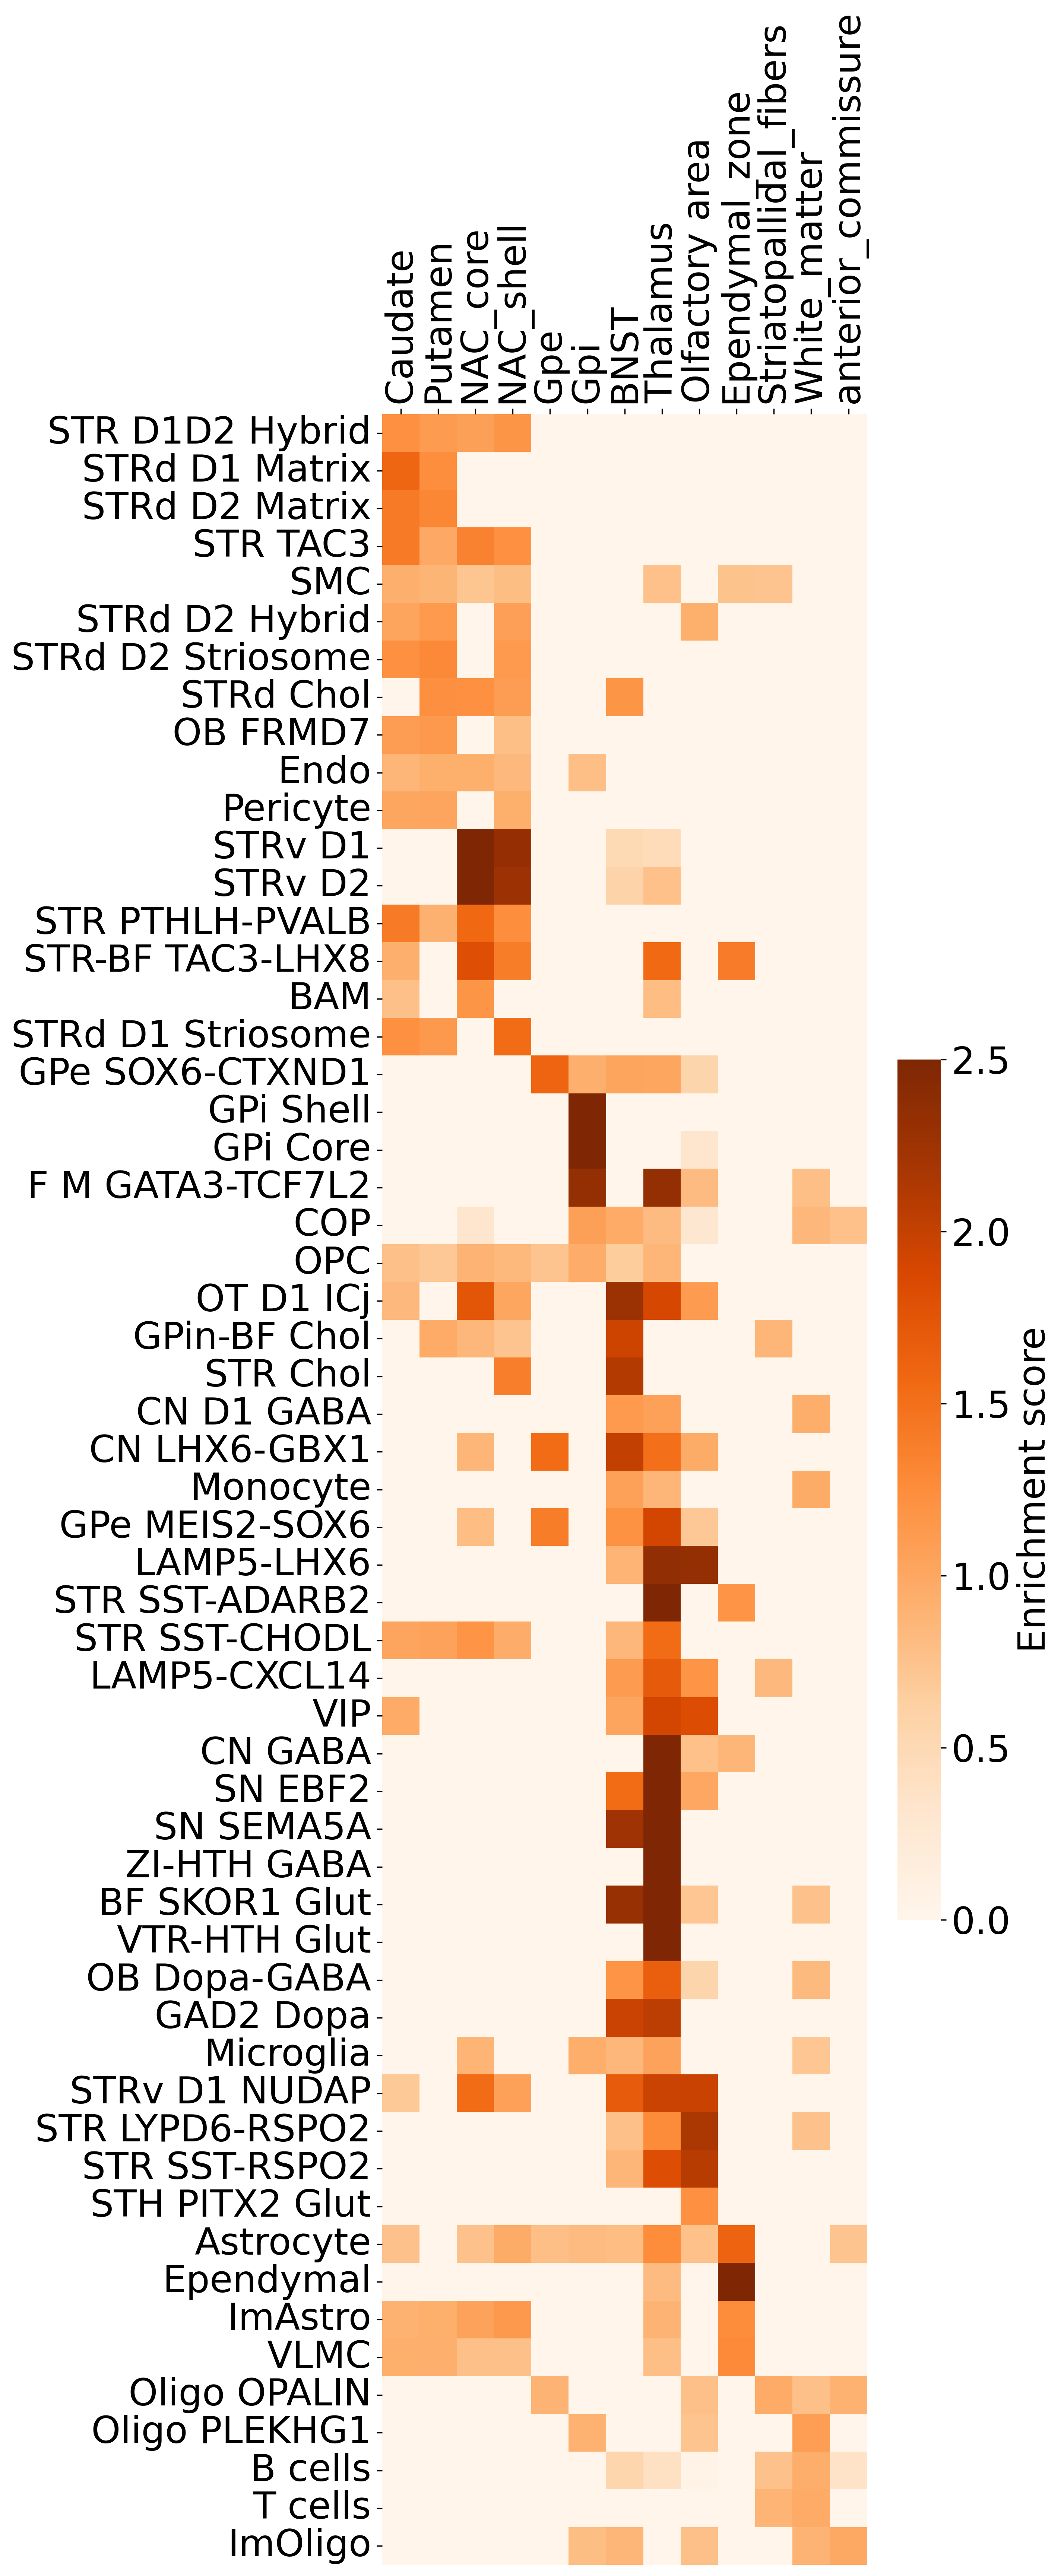

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.size'] = 24

keep = np.isnan(observed_region_enrichment_df_filtered.values).all(axis=-1)
observed_region_enrichment_df_filtered = observed_region_enrichment_df_filtered[~keep].copy()
heatmap_matrix = np.log1p(observed_region_enrichment_df_filtered.values)


significant_celltypes = np.array(observed_region_enrichment_df_filtered.index)
spatial_modules = np.array(observed_region_enrichment_df_filtered.columns)

enriched_idx = np.nanargmax(heatmap_matrix,axis=-1)

heatmap_matrix_sorted = []
significant_celltypes_sorted = []
for idx in np.unique(np.sort(enriched_idx)):
    keep = enriched_idx == idx
    subsorted_matrix = []
    subsorted_celltypes = []
    # then sort them based on the class name 
    for class_ in ['CN LGE GABA', 'CN MGE GABA', 'CN CGE GABA', 'CN GABA-Glut', 'F M GABA', 'F M Glut','Cx GABA','M Dopa','OPC-Oligo','Astro-Epen', 'Immune', 'Vascular']:
        keep_class = np.isin(significant_celltypes[keep], class_2_group[class_])
        subsorted_matrix += [heatmap_matrix[keep][keep_class]]
        subsorted_celltypes += [significant_celltypes[keep][keep_class]]
    subsorted_matrix = np.vstack(subsorted_matrix)
    heatmap_matrix_sorted.append(subsorted_matrix)
    
    subsorted_celltypes = np.hstack(subsorted_celltypes)
    significant_celltypes_sorted.append(subsorted_celltypes)


# sort_idx = np.argsort(enriched_idx)
# significant_celltypes_sorted = significant_celltypes[sort_idx] # Also sort the celltypes
# heatmap_matrix = heatmap_matrix[sort_idx,:].copy()
significant_celltypes_sorted = np.hstack(significant_celltypes_sorted)
heatmap_matrix_sorted = np.vstack(heatmap_matrix_sorted)

# remove the celltypes that do not shown any enrichement in any of the regions
low_cells = ['SN GATA3-PVALB','SOX6 Dopa','CALB1 Dopa']
remove_cells = ~np.isin(significant_celltypes_sorted,low_cells)
heatmap_matrix_sorted = heatmap_matrix_sorted[remove_cells,:]
significant_celltypes_sorted = significant_celltypes_sorted[remove_cells]

fig,ax = plt.subplots(1,1,dpi = 300, figsize = (7,25))
sns.heatmap(heatmap_matrix_sorted,
            cmap = 'Oranges',
            linewidths=0., 
            linecolor='white',
            yticklabels= significant_celltypes_sorted, 
            xticklabels=spatial_modules,
            cbar_kws={'label':'Enrichment score', 'shrink':0.4},
            ax = ax, 
            vmin = 0,
            vmax = 2.5)

ytick_loc =  ax.get_yticks()
ax.set_yticks(ytick_loc,labels=significant_celltypes_sorted, rotation=0,)

xtick_loc =  ax.get_xticks()
ax.set_xticks(xtick_loc,labels=spatial_modules, rotation=90, va = 'bottom')
ax.xaxis.tick_top()
ax.set_frame_on(True)

if False:
    # add axis on the side to show the 
    bbox = ax.get_position()
    ax_regionlabel = fig.add_axes([bbox.xmin - bbox.width * 0.02, bbox.ymin, 0.02*bbox.width, bbox.height ])
    region_colors = tuple(list(region_cmap.values())) #('C0', 'C1', 'C2')
    region_cmap_ = mpl.colors.LinearSegmentedColormap.from_list('', region_colors, len(region_colors))
    sns.heatmap(
                np.arange(len(region_cmap))[:,np.newaxis],
                xticklabels = False,
                yticklabels = False,
                ax = ax_regionlabel,
                cmap = region_cmap_,
                cbar = None
    )

# ax.set_title(np.unique(obs_df['samples']))
plt.savefig(r'/../../../figures/spatialmodule_celltype_enrichment_heatmap_shortname_vertical_updated.png',bbox_inches = 'tight')
plt.savefig(r'/../../../figures/spatialmodule_celltype_enrichment_heatmap_shortname_vertical_updated.tif',bbox_inches = 'tight')
plt.savefig(r'/../../../figures/GlobalSpatialModule_Focus_Figure/spatialmodule_celltype_enrichment_heatmap_shortname_vertical_updated.eps',bbox_inches = 'tight')
plt.show()

### Testing signifiance (Rank-sum test) of cell types showing enrichement difference between Caudate and Putamen

- Compute teh enrichment score the cell type between caudate and putamen for each sample individually, Then use rank sum test to get p-value.

1. STR FS PTHLH-PVALB GABA

In [8]:
from tqdm import tqdm 
import warnings
warnings.filterwarnings("ignore") 
obs_df_CaPu = adata.obs.copy()
obs_df_CaPu = obs_df_CaPu[obs_df_CaPu['Final_Major_region_label'].isin(['Caudate','Putamen'])]
region_enrichment_df = []
for sample in np.unique(adata.obs['samples']):
    keep = obs_df_CaPu['samples'] == sample
    obs_df_CaPu_sample = obs_df_CaPu[keep].copy()
    # Get the confusion matrix data frame
    conf_df = get_confusion_count_df(obs_df_CaPu_sample, 'Group_name', 'Final_Major_region_label')

    # Calculate the enrichment matrix data frame
    expected_count_df = get_expected_count_df(conf_df)
    region_enrichment_df += [conf_df / expected_count_df.values]

In [ ]:
region_enrichment_df_PVALB_PTHLH = pd.concat([ df.loc['STR FS PTHLH-PVALB GABA',:].to_frame() for df in region_enrichment_df],axis = 0)
region_enrichment_df_PVALB_PTHLH = region_enrichment_df_PVALB_PTHLH.reset_index()


,Final_Major_region_label,STR FS PTHLH-PVALB GABA
0,Caudate,1.669571
1,Putamen,0.658438
2,Caudate,1.559781
3,Putamen,0.724610
4,Caudate,1.658156
5,Putamen,0.771543
6,Caudate,1.128025
7,Putamen,0.899417


In [ ]:
region_cmap = {
'BNST': '#730520ff',
 'Caudate': '#00d0ffff',
 'Ependymal_zone': '#33bfafff', 
 'Gpe': '#0034f2ff',
 'Gpi': '#f86a04ff',
 'GrayMatter_fibers':  '#ffe119',
 'Internal_Capsule':  '#3cb44b',
 'Putamen': '#f032e6',
 'NAC_shell': '#5d00ffff',
 'NAC_core': '#bfff45',
 'Thalamus': '#808000',#'#fc0404ff',
 'anterior_commissure': '#be08f5ff',
 'whitematter(Olfactory area)': '#dcbeff',
 'IsCj':'#aaffc3',
 'Surrounding layers': "#b7bdb9"
 }
cluster_cmap = np.load(r'/../.../cluster_cmap_final_updated_9172025.npy',allow_pickle=True).item()

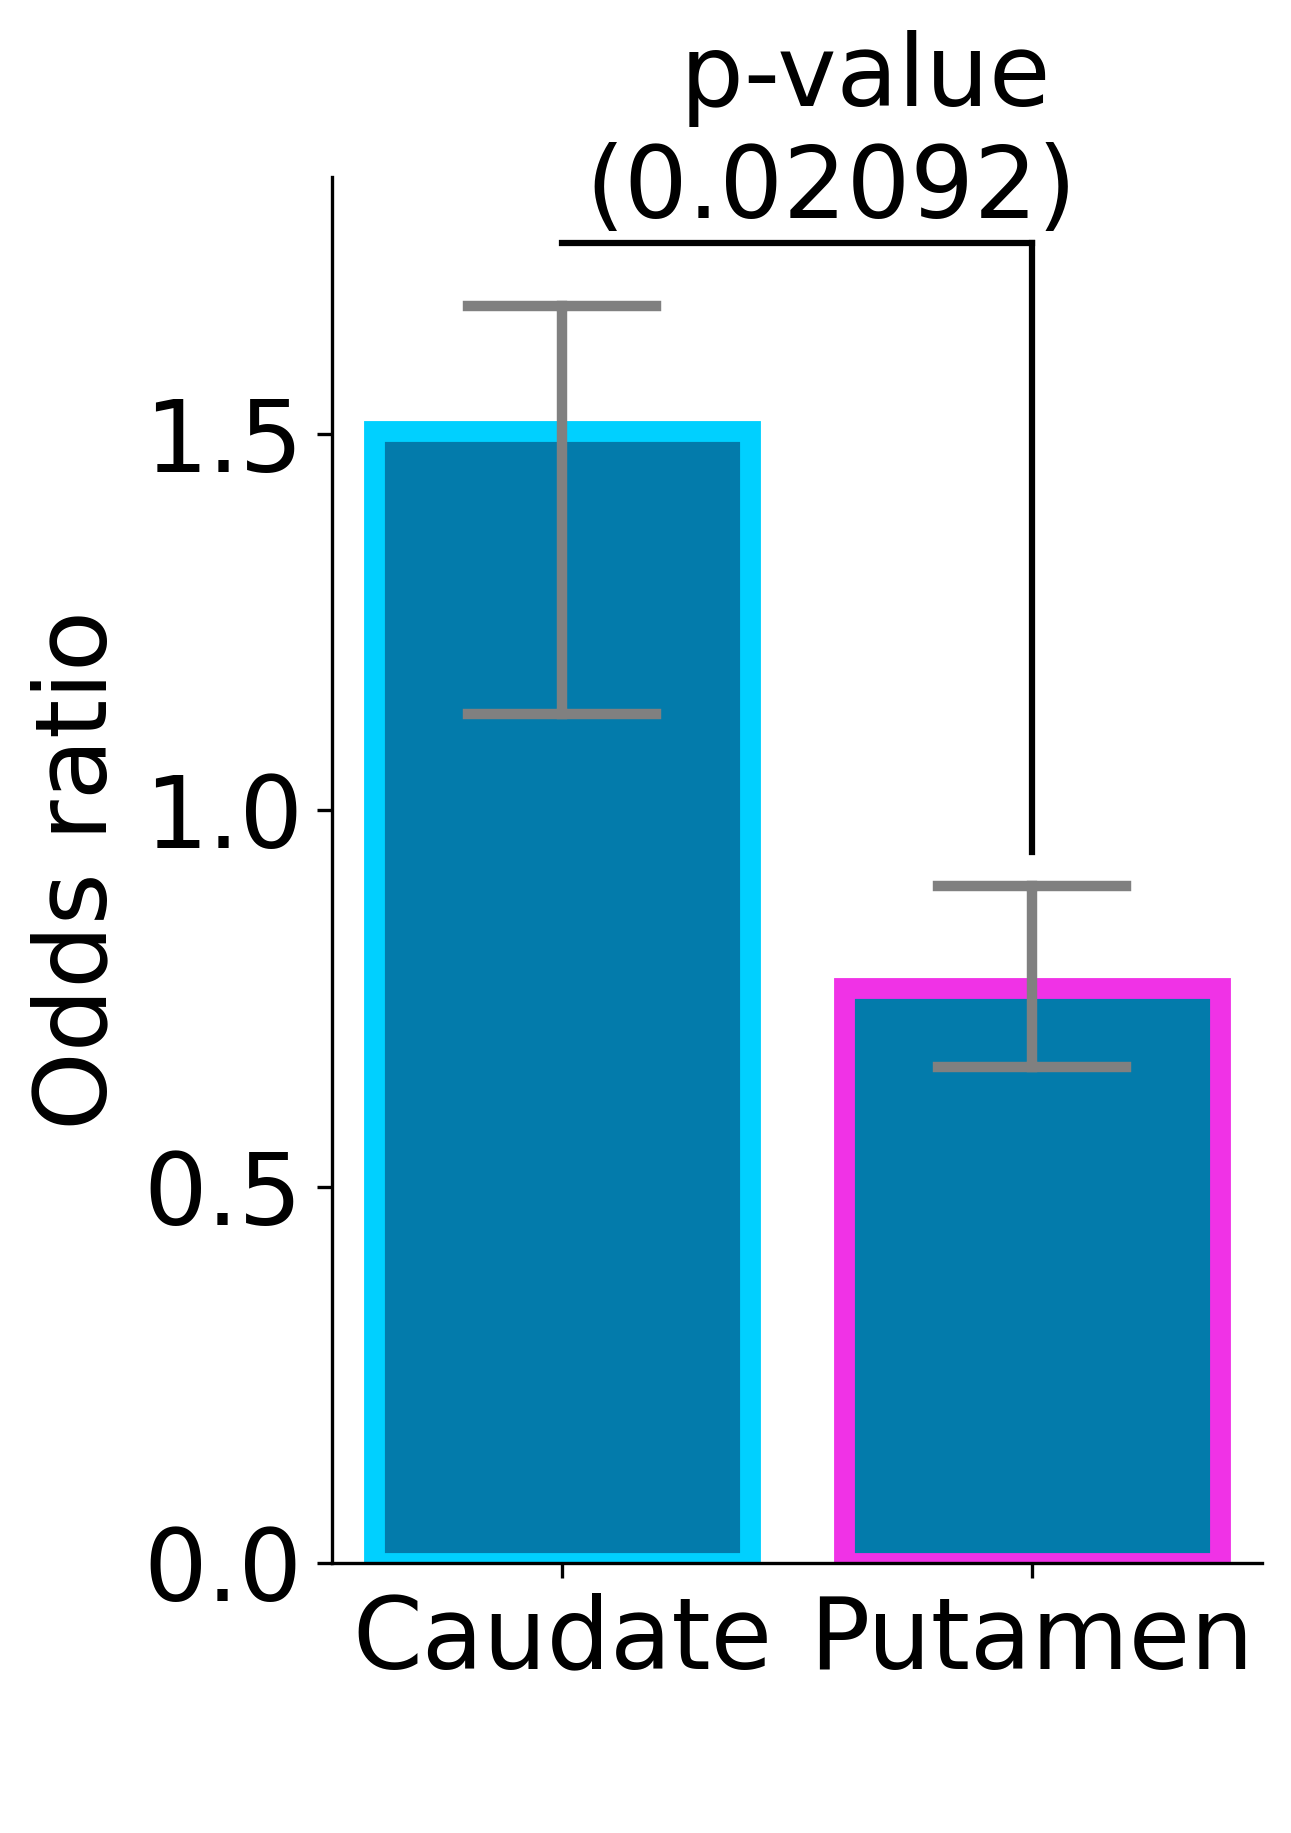

In [ ]:
# Get the statistical significance
import os
import scipy
cu_enrichment = region_enrichment_df_PVALB_PTHLH[region_enrichment_df_PVALB_PTHLH['Final_Major_region_label'] == 'Caudate']['STR FS PTHLH-PVALB GABA'].values
pu_enrichment = region_enrichment_df_PVALB_PTHLH[region_enrichment_df_PVALB_PTHLH['Final_Major_region_label'] == 'Putamen']['STR FS PTHLH-PVALB GABA'].values
res = scipy.stats.ranksums(cu_enrichment,pu_enrichment)
import matplotlib as mpl
plt.rcParams['font.size'] = 24
fig,ax = plt.subplots(1,1, figsize = (4,6), dpi = 300)
sns.barplot(
    region_enrichment_df_PVALB_PTHLH, y="STR FS PTHLH-PVALB GABA", x="Final_Major_region_label",errorbar=("ci", 99.9), capsize=.4,
    err_kws={"color": ".5", "linewidth": 2.5},
    facecolor =cluster_cmap['STR FS PTHLH-PVALB GABA'], edgecolor = [region_cmap[idx] for idx in region_enrichment_df_PVALB_PTHLH['Final_Major_region_label'].unique()], lw = 5,
    ax = ax
)

# draw bracket to indicate significance 
cu_max = region_enrichment_df_PVALB_PTHLH[region_enrichment_df_PVALB_PTHLH['Final_Major_region_label'] == 'Caudate']['STR FS PTHLH-PVALB GABA'].max()
pu_max = region_enrichment_df_PVALB_PTHLH[region_enrichment_df_PVALB_PTHLH['Final_Major_region_label'] == 'Putamen']['STR FS PTHLH-PVALB GABA'].max()
# ax.plot([0,0],[1.01*cu_max,1.1*cu_max], c = 'k')
ax.plot([1,1],[1.05*pu_max,1.05*cu_max], c = 'k')
ax.plot([0,1],[1.05*cu_max,1.05*cu_max], c = 'k')

# print the p-value 
ax.text(0.05,1.07*cu_max,f'   p-value\n({res.pvalue:.4})')
# remove the top and right edge of the frame 
ax.spines[['top', 'right']].set_visible(False)
ax.set_ylabel('Odds ratio')
# ax.set_xlabel('Spatial module')
ax.set_xlabel(' ')
# ax.text(-1.5,1.35*enrich_val[0],f'Enrichment of {celltype1}')
figure_title = 'Ca_Pu_STR_FS_PTHLH_PVALB_enrichement_colored_ranksumtested'

plt.savefig(r'/../../../figures/GlobalSpatialModule_Focus_Figure' + os.sep + f'{figure_title}.png',bbox_inches = 'tight')
plt.savefig(r'/../../../figures/GlobalSpatialModule_Focus_Figure' + os.sep + f'{figure_title}.tif',bbox_inches = 'tight')
plt.savefig(r'/../../../figures/GlobalSpatialModule_Focus_Figure' + os.sep + f'{figure_title}.eps',bbox_inches = 'tight')
plt.show()

B. STRd Cholinergic GABA

In [ ]:
region_enrichment_df_STRd_Chol = pd.concat([ df.loc['STRd Cholinergic GABA',:].to_frame() for df in region_enrichment_df],axis = 0)
region_enrichment_df_STRd_Chol = region_enrichment_df_STRd_Chol.reset_index()


,Final_Major_region_label,STRd Cholinergic GABA
0,Caudate,0.767491
1,Putamen,1.118608
2,Caudate,0.516935
3,Putamen,1.237649
4,Caudate,0.379752
5,Putamen,1.215299
6,Caudate,0.391023
7,Putamen,1.478445


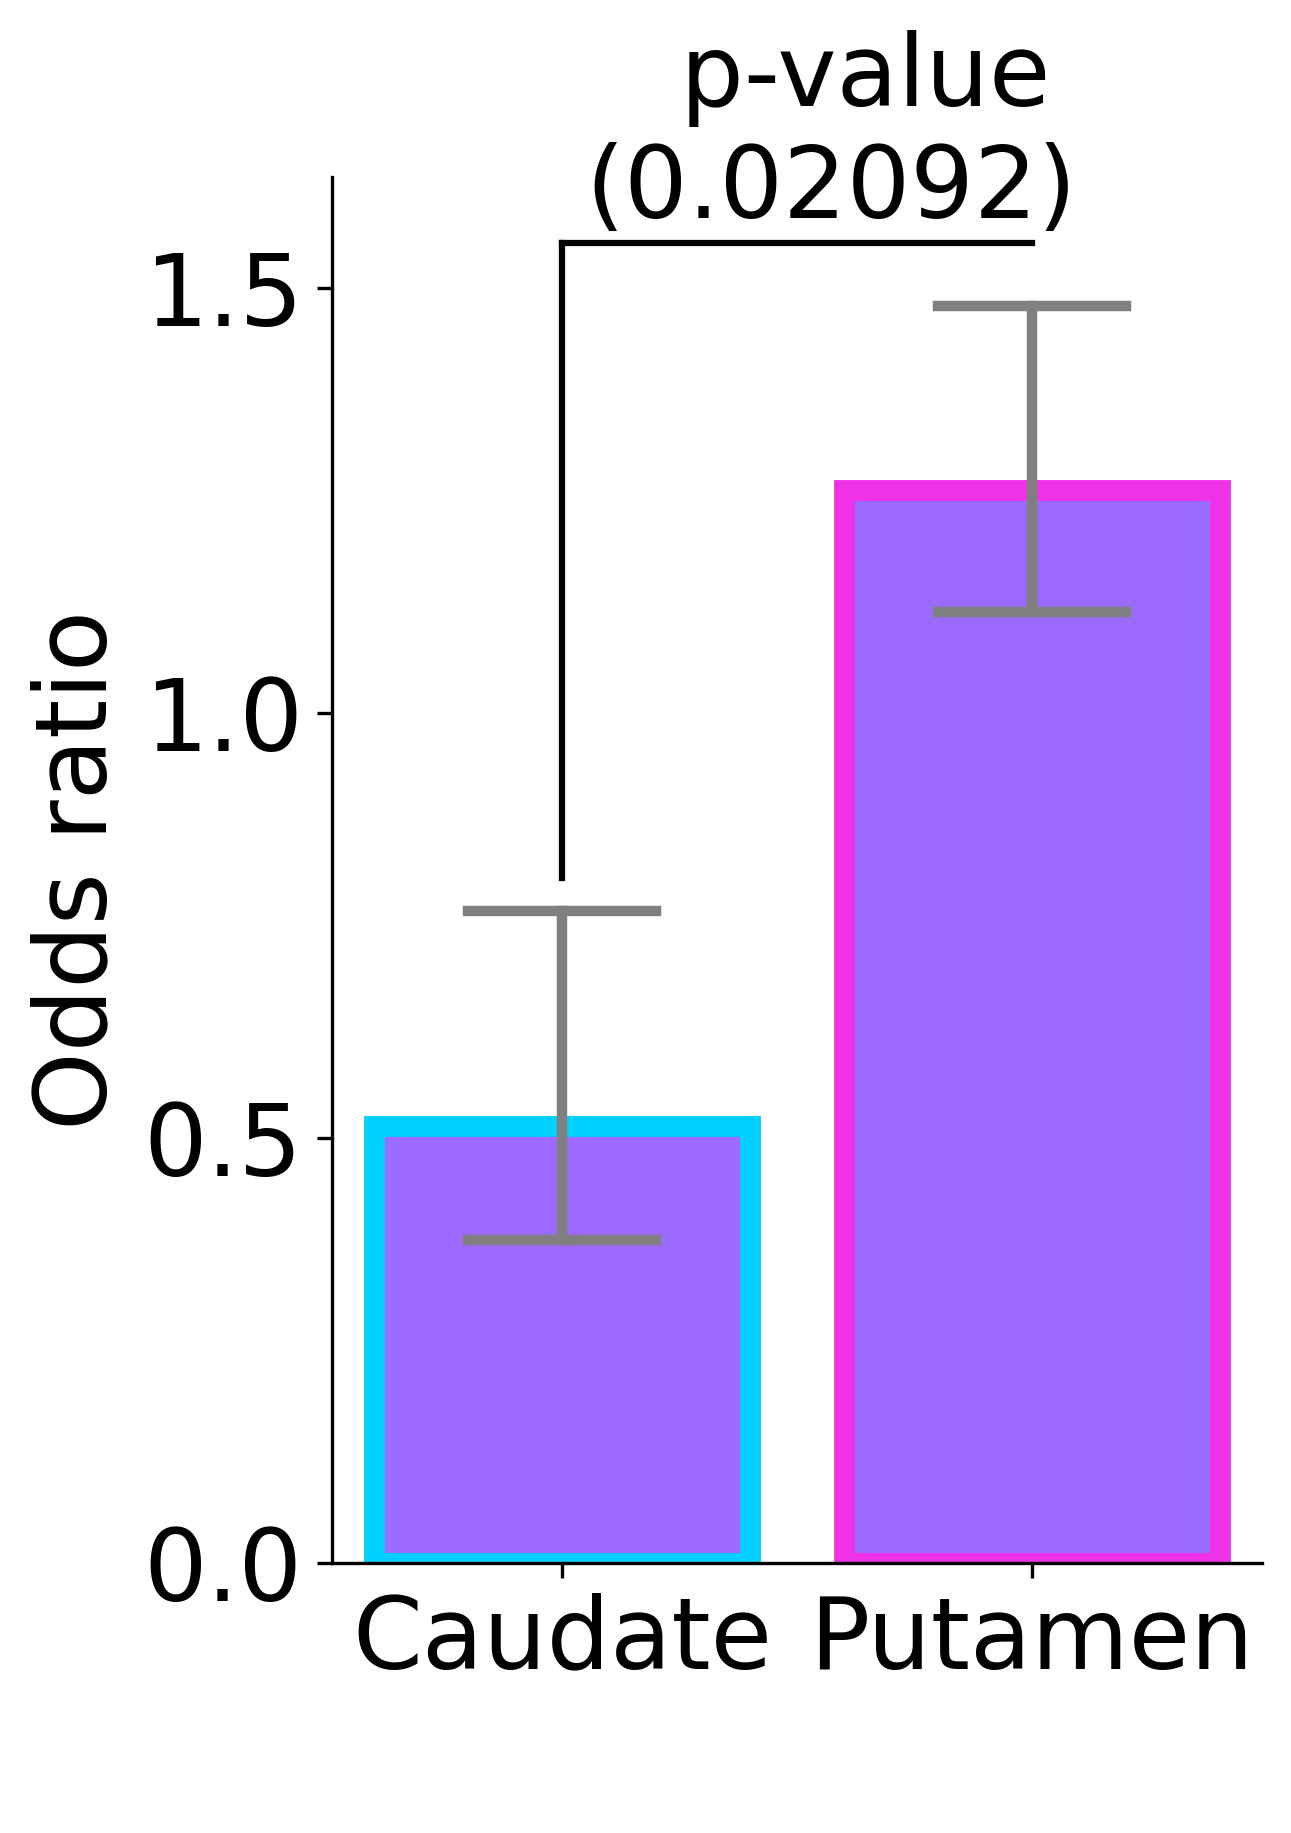

In [ ]:
# Get the statistical significance
import os
import scipy
cu_enrichment = region_enrichment_df_STRd_Chol[region_enrichment_df_STRd_Chol['Final_Major_region_label'] == 'Caudate']['STRd Cholinergic GABA'].values
pu_enrichment = region_enrichment_df_STRd_Chol[region_enrichment_df_STRd_Chol['Final_Major_region_label'] == 'Putamen']['STRd Cholinergic GABA'].values
res = scipy.stats.ranksums(cu_enrichment,pu_enrichment)

import matplotlib as mpl
plt.rcParams['font.size'] = 24
fig,ax = plt.subplots(1,1, figsize = (4,6), dpi = 300)
sns.barplot(
    region_enrichment_df_STRd_Chol, y="STRd Cholinergic GABA", x="Final_Major_region_label",errorbar=("ci", 99.9), capsize=.4,
    err_kws={"color": ".5", "linewidth": 2.5},
    facecolor =cluster_cmap['STRd Cholinergic GABA'], edgecolor = [region_cmap[idx] for idx in region_enrichment_df_STRd_Chol['Final_Major_region_label'].unique()], lw = 5,
    ax = ax
)

# draw bracket to indicate significance 
cu_max = region_enrichment_df_STRd_Chol[region_enrichment_df_STRd_Chol['Final_Major_region_label'] == 'Caudate']['STRd Cholinergic GABA'].max()
pu_max = region_enrichment_df_STRd_Chol[region_enrichment_df_STRd_Chol['Final_Major_region_label'] == 'Putamen']['STRd Cholinergic GABA'].max()
# ax.plot([0,0],[1.01*cu_max,1.1*cu_max], c = 'k')
ax.plot([0,0],[1.05*pu_max,1.05*cu_max], c = 'k')
ax.plot([0,1],[1.05*pu_max,1.05*pu_max], c = 'k')

# print the p-value 
ax.text(0.05,1.07*pu_max,f'   p-value\n({res.pvalue:.4})')
# remove the top and right edge of the frame 
ax.spines[['top', 'right']].set_visible(False)
ax.set_ylabel('Odds ratio')
# ax.set_xlabel('Spatial module')
ax.set_xlabel(' ')
# ax.text(-1.5,1.35*enrich_val[0],f'Enrichment of {celltype1}')
figure_title = 'Ca_Pu_STRd_Cholinergic_GABA_enrichement_colored_ranksumtested'

plt.savefig(r'/../../../figures/GlobalSpatialModule_Focus_Figure' + os.sep + f'{figure_title}.png',bbox_inches = 'tight')
plt.savefig(r'/../../../figures/GlobalSpatialModule_Focus_Figure' + os.sep + f'{figure_title}.tif',bbox_inches = 'tight')
plt.savefig(r'/../../../FigureMaking_notebooks/figures/GlobalSpatialModule_Focus_Figure' + os.sep + f'{figure_title}.eps',bbox_inches = 'tight')
plt.show()